# Predicting sign-ups to a membership programme using logistic regression

The goal is to obtain probabilities of leads applying to a membership programme with a Canadian sport society after being called by one of the society's call centers and to predict the most likely 100 leads to sign up. The programme has restrictions on member intake, so applications can get rejected.

## Overview of methodology
- initial housekeeping (libraries, loading data)
- exploratory data analysis (data examination, data cleaning, data correlation, histograms)
- feature engineering (feature encoding, feature scaling)
- model & predictions (model building, model evaluation, making predictions)

## Initial housekeeping

### Import the relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import average_precision_score

### Load the dataset

In [2]:
# load data
dataset = pd.read_csv('regression_dataset.csv')

## Exploratory data analysis

In [3]:
# display the data
dataset.head(10)

,Name,Phone Number,Province,Sport,Game Attendance,Age,Called,Call Center,Call Outcome,Applied,Decision
0,Miya Charles,728190618071,New Brunswick,rugby,0.20,33,False,East,NaN,NaN,NaN
1,Deangelo Cobb,255217276432,Alberta,soccer,0.81,24,False,West,NaN,NaN,NaN
2,Adam Rogers,538482482123,Ontario,baseball,0.30,33,False,South,NaN,NaN,NaN
3,Demarion Dudley,913979679898,British Columbia,ice hockey,0.43,26,False,West,NaN,NaN,NaN
4,Scott Medina,676902221026,Ontario,ice hockey,0.36,25,False,South,NaN,NaN,NaN
5,Tessa Lowe,822568222276,Nova Scotia,rugby,0.66,29,False,East,NaN,NaN,NaN
6,Jaylin Bailey,422215394903,British Columbia,ice hockey,0.61,25,False,West,NaN,NaN,NaN
7,Francisco Curtis,775967173668,Alberta,soccer,0.40,20,True,West,interested,True,rejected
8,Osvaldo Griffin,596918287046,British Columbia,cricket,0.30,28,False,West,NaN,NaN,NaN
9,Yoselin Moyer,242633357110,Ontario,tennis,0.31,22,True,South,not interested,False,NaN


The dataset to be used for analysis is contained in a single spreadsheet, displayed above. Apart from basic lead data - *Name*, *Phone Number*, *Province* and *Age* (in years), leads' favourite sport and game attendance data are available, obtained through a 5-year-long partnership with Canadian central sport ticket distribution company. *Game Attendance* is a 5-year average percentage of attended home league games of a team for which lead's attendance is the biggest. *Sport* is determined based on what sport the team with the highest *Game Attendance* is playing. In both cases only games for which tickets were purchased through the distribution company are counted towards attended games.  

The loaded dataset contains both leads that have already been called and ones that have not been, determined by the *Called* variable. From the perspective of the programme, these are the datasets which will be used for regression training and testing and the dataset on which the predictions will be made. They will be separated at a later stage, however, it is beneficial to keep them as a single dataframe for now.

*Call Center* determines which call center the lead was / would be called from. *Call Outcome* is marked down after a call from a fixed list. *Applied* determines whether the lead applied to the programme after the call, and *Decision* determines if they were approved or rejected

The lead data do not represent real people but is a realistic representation of real-life business data available for such analysis. 

In [4]:
# check for missing values
dataset.isna().sum() 

Name                  0
Phone Number          0
Province              0
Sport                 0
Game Attendance       0
Age                   0
Called                0
Call Center           0
Call Outcome       7280
Applied            7280
Decision           9231
dtype: int64

In [5]:
# check how many leads have not been called yet
len(dataset[dataset['Called'] == False])

7280

In [6]:
# check what values Applied takes for leads that have not been called
dataset[dataset['Called']==False]['Applied'].value_counts()

Series([], Name: count, dtype: int64)

The only missing values are in the last 3 columns. *Call Outcome* and *Decision* are of no interest in this particular problem, so they can be disregarded. However, the missing values make sense - they should be missing for leads that have not been called and have not applied, respecively.  

For *Applied* it can be seen that all the missing values are rows of leads that have not been called yet which is expected.

In [7]:
# check basic statistics of numerical columns
dataset.describe()

,Phone Number,Game Attendance,Age
count,1.000000e+04,10000.000000,10000.000000
mean,4.994903e+11,0.441094,37.108000
std,2.914145e+11,0.220783,19.395968
min,3.807313e+07,0.060000,18.000000
25%,2.508587e+11,0.260000,23.000000
50%,4.950398e+11,0.430000,31.000000
75%,7.568304e+11,0.610000,44.000000
max,9.999539e+11,1.000000,201.000000


### Age column cleaning

In [8]:
# print all unique Age values
print([int(x) for x in sorted(dataset['Age'].astype(int).unique(),reverse=True)])

[201, 197, 177, 176, 168, 161, 158, 156, 155, 153, 149, 148, 147, 146, 145, 144, 142, 141, 140, 139, 137, 136, 132, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18]


*Age* max value of 201 is unrealistically high. It can be also seen that it is followed by a number of smaller but still urealistic values. With the available knowledge it is hard to say how those high values appeared there and what the actual *Age* values are for those leads. Therefore, it was deemed suboptimal to try to substitute the high values with *Age* median or mode, or setting all values above certain threshold to that threshold (however, all these approaches have been tried and were not found to improve the model's performance). Keeping the values was also decided againts, as modelling sign-up probability for people of unreaslistic age makes little sense. Therefore, it was decided that such applications are best disregarded if they do not constitute too big a fraction of the entire dataset. 

In [9]:
# a quick check to get an idea of proportion of data that might be disregarded
len(dataset[dataset['Age'] > 100])

134

134 rows constitute a fairly small fraction of the dataset so any threshold above 100 will be acceptable. One of the approaches that can be taken is finding the maximum age for which an application was approved, as it seems to be more likely that such a  lead was screened in more detail and their age is correct.

In [10]:
# find the max age for approved application
int(dataset.loc[dataset['Decision'] == 'approved', 'Age'].max())

105

The highest *Age* for an approved application is 105 - above 100 and realistic (even if unlikely). The value will be used as the threshold. Below the exact percentage of leads over that age is calculated.

In [11]:
# calculate percentage of leads and called leads over 105 according to the provided data
called_over105 = len(dataset[(dataset['Age'] > 105) & (dataset['Called'])]) # leads over 105 which were called
over105 = len(dataset[dataset['Age'] > 105]) # all leads over 105
called = len(dataset[dataset['Called']]) # leads which were called
percentage_called = round(called_over105/called,3) # percentage of called leads which are over 105  
percentage_total = round(over105/len(dataset),3) # percentage of all leads which are over 105
# create a dataframe to display the results
age_stats = {'Over 105':[called_over105, over105],
            'Total':[called, len(dataset)],
            'Percentage':[percentage_called, percentage_total]}
age_stats_df = pd.DataFrame(age_stats)
age_stats_df.index = ['Called','Total']
age_stats_df

,Over 105,Total,Percentage
Called,32,2720,0.012
Total,107,10000,0.011


For both called and all leads, the leads with *Age* values higher than 105 constitute slightly above 1%, so it was deemed acceptable to disregard them.

### Checkpoint 1

In [12]:
# make a copy of the dataframe keeping only leads 105 years old or younger
dataset2 = dataset[dataset['Age'] <= 105].copy()

In [13]:
# check basic statistics of numerical columns to see the changes in the Age column
dataset2.describe()

,Phone Number,Game Attendance,Age
count,9.893000e+03,9893.000000,9893.000000
mean,4.994689e+11,0.441099,36.143435
std,2.915263e+11,0.220597,17.010081
min,3.807313e+07,0.060000,18.000000
25%,2.509555e+11,0.260000,23.000000
50%,4.937647e+11,0.430000,31.000000
75%,7.570934e+11,0.610000,44.000000
max,9.999539e+11,1.000000,105.000000


### Examining other columns

#### Province


In [14]:
# check occurrences of all Province values
province_value_count = dataset2['Province'].value_counts()
province_value_count

Province
Ontario                      2198
Quebec                       1595
British Columbia             1103
Alberta                      1102
Manitoba                     1096
Saskatchewan                 1054
Nova Scotia                   566
New Brunswick                 551
Newfoundland and Labrador     273
Prince Edward Island          255
Northwest Territories          52
Yukon                          42
Nunavut                         6
Name: count, dtype: int64

In [15]:
# check occurrences of all Province values for the leads who have been called
province_value_count_called = dataset2[dataset2['Called']]['Province'].value_counts()
province_value_count_called

Province
Ontario                      624
Quebec                       425
Alberta                      302
British Columbia             288
Manitoba                     284
Saskatchewan                 282
Nova Scotia                  161
New Brunswick                141
Newfoundland and Labrador     85
Prince Edward Island          72
Northwest Territories         11
Yukon                         11
Nunavut                        2
Name: count, dtype: int64

In [16]:
# check the ratios
province_value_count_ratio = province_value_count_called / province_value_count
province_value_count_ratio

Province
Alberta                      0.274047
British Columbia             0.261106
Manitoba                     0.259124
New Brunswick                0.255898
Newfoundland and Labrador    0.311355
Northwest Territories        0.211538
Nova Scotia                  0.284452
Nunavut                      0.333333
Ontario                      0.283894
Prince Edward Island         0.282353
Quebec                       0.266458
Saskatchewan                 0.267552
Yukon                        0.261905
Name: count, dtype: float64

The only manipulation which will be performed on this feature is combining the last 3 *Province* categories as they are poorly represented in the data set. It also makes sense as they are the 3 Northern Canadian territories.

In [17]:
# combine the 3 values in 1 - Territories
dataset2.loc[:,'Province'] = dataset2.loc[:,'Province'].replace(['Northwest Territories', 'Yukon', 'Nunavut'], 'Territories')

#### Sport

In [18]:
# check occurrences of all Sport values
sport_value_count = dataset2['Sport'].value_counts()
sport_value_count

Sport
ice hockey    2877
soccer        2082
baseball      1723
cricket       1462
tennis         904
rugby          585
basketball     260
Name: count, dtype: int64

In [19]:
# check occurrences of all Sport values for the leads who have been called
sport_value_count_called = dataset2[dataset2['Called']]['Sport'].value_counts()
sport_value_count_called

Sport
ice hockey    788
soccer        569
baseball      454
cricket       392
tennis        253
rugby         161
basketball     71
Name: count, dtype: int64

In [20]:
# check the ratios
sport_value_count_ratio = sport_value_count_called / sport_value_count
sport_value_count_ratio

Sport
ice hockey    0.273896
soccer        0.273295
baseball      0.263494
cricket       0.268126
tennis        0.279867
rugby         0.275214
basketball    0.273077
Name: count, dtype: float64

No cleaning will be performed for this feature...

#### Game Attenddance

... and neither for *Game Attendance*. However, the correlation with *Age* should be checked to see if one of the features should be dropped.

In [21]:
dataset2[['Age','Game Attendance']].corr()

,Age,Game Attendance
Age,1.000000,0.012024
Game Attendance,0.012024,1.000000


Clearly, there is little correlation between the two. 

#### Call Center

In [22]:
# check occurrences of all Call Center values
center_value_count = dataset2['Call Center'].value_counts()
center_value_count

Call Center
South    3294
West     3259
East     3240
North     100
Name: count, dtype: int64

In [23]:
# examine relationship with Province
province_south_center = dataset2[dataset2['Call Center'] == 'South']['Province'].value_counts()
province_west_center = dataset2[dataset2['Call Center'] == 'West']['Province'].value_counts()
province_east_center = dataset2[dataset2['Call Center'] == 'East']['Province'].value_counts()
province_north_center = dataset2[dataset2['Call Center'] == 'North']['Province'].value_counts()

In [24]:
province_south_center

Province
Ontario     2198
Manitoba    1096
Name: count, dtype: int64

In [25]:
province_west_center

Province
British Columbia    1103
Alberta             1102
Saskatchewan        1054
Name: count, dtype: int64

In [26]:
province_east_center

Province
Quebec                       1595
Nova Scotia                   566
New Brunswick                 551
Newfoundland and Labrador     273
Prince Edward Island          255
Name: count, dtype: int64

In [27]:
province_north_center

Province
Territories    100
Name: count, dtype: int64

*Call Center* basically groups *Province* values together by the region of Canada they are located in and does not provide any new information. It will be therefore removed.

#### Called, Call Outcome & Decision
These will be removed as well. The predictions will be made for uncalled leads so *Call Outcome* is not useful for this problem. Division of the dataset can be done using *Applied* column so the *Called* column is also unnecesary.

In [28]:
dataset2.drop(columns = ['Called', 'Call Center', 'Call Outcome', 'Decision'], axis=1, inplace=True)

#### Applied
*Applied* is the target column.

In [29]:
# check Applied statistics
dataset2['Applied'].value_counts()

Applied
False    1928
True      760
Name: count, dtype: int64

In [30]:
# display the dataframe after modifications
dataset2.head(10)

,Name,Phone Number,Province,Sport,Game Attendance,Age,Applied
0,Miya Charles,728190618071,New Brunswick,rugby,0.20,33,NaN
1,Deangelo Cobb,255217276432,Alberta,soccer,0.81,24,NaN
2,Adam Rogers,538482482123,Ontario,baseball,0.30,33,NaN
3,Demarion Dudley,913979679898,British Columbia,ice hockey,0.43,26,NaN
4,Scott Medina,676902221026,Ontario,ice hockey,0.36,25,NaN
5,Tessa Lowe,822568222276,Nova Scotia,rugby,0.66,29,NaN
6,Jaylin Bailey,422215394903,British Columbia,ice hockey,0.61,25,NaN
7,Francisco Curtis,775967173668,Alberta,soccer,0.40,20,True
8,Osvaldo Griffin,596918287046,British Columbia,cricket,0.30,28,NaN
9,Yoselin Moyer,242633357110,Ontario,tennis,0.31,22,False


### Histograms
Once the data have been cleaned, the histograms can be created.

#### Age

(array([495., 479., 458., 384., 372., 376., 354., 336., 339., 309., 284.,
        281., 274., 267., 262., 209., 221., 208., 209., 234., 199., 188.,
        191., 163., 158., 146., 129., 126., 120., 105., 116., 107.,  94.,
         92.,  73.,  92.,  76.,  78.,  98.,  65.,  71.,  62.,  44.,  52.,
         39.,  49.,  44.,  38.,  43.,  35.,  38.,  27.,  27.,  36.,  37.,
         27.,  20.,  38.,  26.,  23.,  24.,  12.,  18.,  25.,  15.,  17.,
         17.,  11.,  21.,  10.,  15.,   8.,  18.,  18.,  12.,  15.,  10.,
         12.,   6.,   9.,  10.,  13.,   7.,   8.,   3.,   5.,  11.]),
 array([ 18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,
         29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,
         40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,
         51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,
         62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,
         73.,  74.,  75.,  76.,  77.,  78.

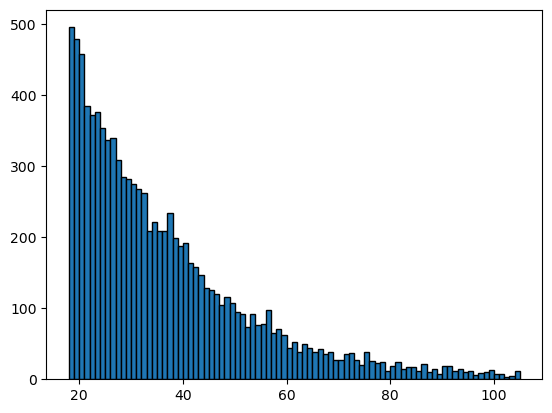

In [31]:
# plot Age histogram to see the distribution
plt.hist(dataset2['Age'], bins=(dataset2['Age'].max()-dataset2['Age'].min()), edgecolor='black')

The shape of the *Age* distribution warrants considerations on taking the log of *Age* values. However, this approach has been tried and was not found to improve the model's performance.

#### Province

(array([ 551., 1102., 2198., 1103.,  566., 1054., 1595., 1096.,  273.,
         255.,  100.]),
 array([ 0.        ,  0.90909091,  1.81818182,  2.72727273,  3.63636364,
         4.54545455,  5.45454545,  6.36363636,  7.27272727,  8.18181818,
         9.09090909, 10.        ]),
 <BarContainer object of 11 artists>)

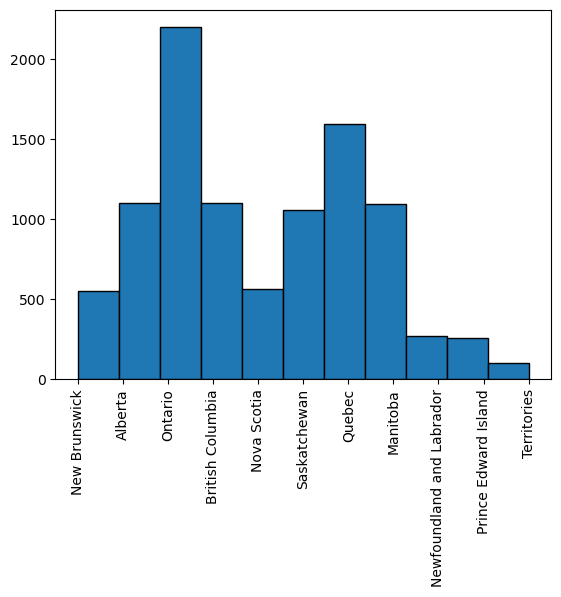

In [32]:
# plot Province histogram to see the distribution
plt.xticks(rotation=90)
plt.hist(dataset2['Province'], bins=dataset2['Province'].nunique(), edgecolor='black')

#### Sport

(array([ 585., 2082., 1723., 2877., 1462.,  904.,  260.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <BarContainer object of 7 artists>)

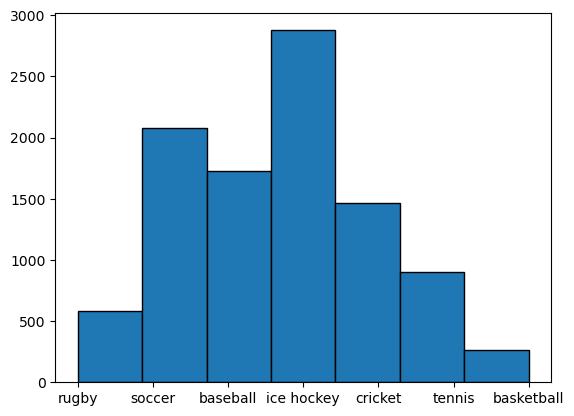

In [33]:
# plot Sport histogram to see the distribution
plt.hist(dataset2['Sport'], bins=dataset2['Sport'].nunique(), edgecolor='black')

#### Game Attendance

(array([ 28.,  41.,  82.,  93., 123., 122., 143., 144., 134., 143., 150.,
        144., 129., 139., 127., 136., 120., 148., 136., 138., 137., 157.,
        129., 158., 137., 161., 148., 160., 134., 144., 151., 156., 138.,
        139., 147., 143., 147., 134., 159., 145., 139., 125., 157., 153.,
        133., 133., 146., 138., 154., 127., 129., 139., 135., 132., 117.,
        109., 119.,  98., 112., 116., 126., 108.,  99., 113., 110., 100.,
         83.,  89.,  63., 100.,  83.,  73.,  66.,  62.,  72.,  52.,  47.,
         49.,  47.,  46.,  55.,  44.,  31.,  32.,  37.,  33.,  23.,  17.,
         22.,  18.,  16.,  13.,   5.,   3.,   1.]),
 array([0.06      , 0.06989474, 0.07978947, 0.08968421, 0.09957895,
        0.10947368, 0.11936842, 0.12926316, 0.13915789, 0.14905263,
        0.15894737, 0.16884211, 0.17873684, 0.18863158, 0.19852632,
        0.20842105, 0.21831579, 0.22821053, 0.23810526, 0.248     ,
        0.25789474, 0.26778947, 0.27768421, 0.28757895, 0.29747368,
        0.307368

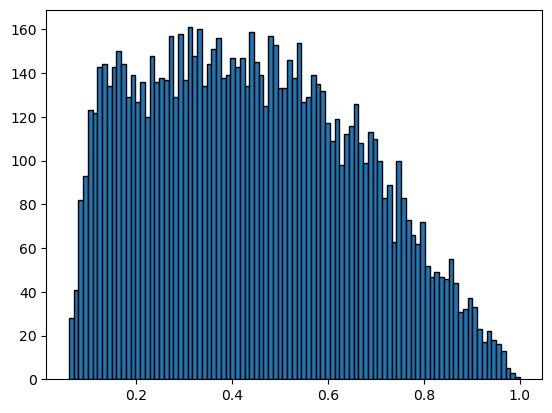

In [34]:
# plot Game Attendance histogram to see the distribution
plt.hist(dataset2['Game Attendance'], bins=int(1+100*(dataset2['Game Attendance'].max()-dataset2['Game Attendance'].min())),
         edgecolor='black')

## Feature enginnering

### One-hot encoding
*Province* and *Sport* will be encoded as they are categorical features. This is necessary to train the model.

In [35]:
# obtain dataframe with dummy variables 
dataset_dummies = pd.get_dummies(dataset2[['Province', 'Sport']])
dataset_dummies = dataset_dummies.astype(int)

In [36]:
# rename the dummy columns
dataset_dummies.columns = dataset_dummies.columns.str.replace('Province_', '')
dataset_dummies.columns = dataset_dummies.columns.str.replace('Sport_', '')

In [37]:
# drop one dummy column per each original categorical variable to avoid correlation
dataset_dummies = dataset_dummies.drop(columns = ['Territories','basketball'])

In [38]:
# display the dataframe
dataset_dummies.head(10)

,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Nova Scotia,Ontario,Prince Edward Island,Quebec,Saskatchewan,baseball,cricket,ice hockey,rugby,soccer,tennis
0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
6,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
9,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


### Checkpoint 2

In [39]:
# drop original categorical columns
dataset3 = dataset2.drop(columns = ['Province','Sport'], axis=1).copy()
# add dummy variables to the main dataframe
dataset3 = pd.concat([dataset3, dataset_dummies], axis=1)
# display column names
dataset3.columns

Index(['Name', 'Phone Number', 'Game Attendance', 'Age', 'Applied', 'Alberta',
       'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Nova Scotia', 'Ontario',
       'Prince Edward Island', 'Quebec', 'Saskatchewan', 'baseball', 'cricket',
       'ice hockey', 'rugby', 'soccer', 'tennis'],
      dtype='object')

In [40]:
# change column order
dataset3 = dataset3[['Name', 'Phone Number', 'Age', 'Game Attendance', 'Alberta', 'British Columbia', 'Manitoba',
       'New Brunswick', 'Newfoundland and Labrador', 'Nova Scotia', 'Ontario', 'Prince Edward Island', 'Quebec',
       'Saskatchewan', 'baseball', 'cricket', 'ice hockey', 'rugby', 'soccer', 'tennis', 'Applied']]

In [41]:
# display the dataframe
dataset3.head(10)

,Name,Phone Number,Age,Game Attendance,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Nova Scotia,...,Prince Edward Island,Quebec,Saskatchewan,baseball,cricket,ice hockey,rugby,soccer,tennis,Applied
0,Miya Charles,728190618071,33,0.20,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,NaN
1,Deangelo Cobb,255217276432,24,0.81,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,NaN
2,Adam Rogers,538482482123,33,0.30,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,NaN
3,Demarion Dudley,913979679898,26,0.43,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,NaN
4,Scott Medina,676902221026,25,0.36,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,NaN
5,Tessa Lowe,822568222276,29,0.66,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,NaN
6,Jaylin Bailey,422215394903,25,0.61,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,NaN
7,Francisco Curtis,775967173668,20,0.40,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,True
8,Osvaldo Griffin,596918287046,28,0.30,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,NaN
9,Yoselin Moyer,242633357110,22,0.31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False


### Checkpoint 3 - separating the dataset

In [42]:
# separate into dataset to be used for training and testing the regression model
dataset_fit = dataset3[~dataset3['Applied'].isna()].copy()
# and the dataset on which predictions will be made
dataset_predict = dataset3[dataset3['Applied'].isna()].copy()
# rename column Applied to Applying Probability
dataset_predict.rename(columns={'Applied': 'Applying Probability'}, inplace=True)
# change target data type from bool to int
dataset_fit['Applied'] = dataset_fit['Applied'].astype(int)
# see the value count in the dataframe for fitting (expecting 0s and 1s)
dataset_fit['Applied'].value_counts()

Applied
0    1928
1     760
Name: count, dtype: int64

In [43]:
# see the value count in the dataframe for predicting (expecting missing values)
dataset_predict['Applying Probability'].value_counts()

Series([], Name: count, dtype: int64)

### Splitting into train and test sets

In [44]:
# perform the split with test size of 20% and defined random state so the results can be reproduced
X_train, X_test, y_train, y_test = train_test_split(dataset_fit.drop(columns = ['Name', 'Phone Number', 'Applied']),
                                                    dataset_fit['Applied'], test_size = 0.2, random_state = 42)

### Feature scaling
Using StandardScaler, numerical features will be standardized by removing the mean and scaling to unit variance. This is necessary to achieve optimal model performance.

In [45]:
# initialize the StandardScaler object
scaler = StandardScaler()
# fit scaling and scale numerical variables in training set, store scaled variables in a new df
num_val_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[['Age', 'Game Attendance']]))
# scale numerical variables in test set, store scaled variables in a new df
num_val_test_scaled = pd.DataFrame(scaler.transform(X_test[['Age', 'Game Attendance']]))
# match indexing of new dfs with the main ones
num_val_train_scaled.index = X_train.index.values
num_val_test_scaled.index = X_test.index.values
# substitute unscaled variables in main dfs with the scaled ones
X_train['Age'] = num_val_train_scaled[0]
X_test['Age'] = num_val_test_scaled[0]
X_train['Game Attendance'] = num_val_train_scaled[1]
X_test['Game Attendance'] = num_val_test_scaled[1]

## Model & predictions

### Model building
As seen before, there is a target label imbalance in the dataset. This requires addressing, as otherwise the model will perform suboptimally. There is a number of approaches that can be taken, for this problem class weights will be used. Cross-validation will be also applied during model building to obtain average evaluation metric score and reduce the risk of overfitting.

Accuracy is not a reliable metric for problems with imbalanced target labels. There is a number of metrics suited for dealing with such, such as recall, precision or F1 score. However, they are all calculated using assigned predicted labels and hence depend on and can be manipulated by the assignment threshold. The problem at hand focuses on probabilities and hence a more suited metric is the Area Under the Precision-Recall Curve (AUPRC), also known as average precision. For this setup it is also superior to another metric working with predicted probabilities, ROC-AUC, as it better measures the ability of the model to find positives faster (https://towardsdatascience.com/imbalanced-data-stop-using-roc-auc-and-use-auprc-instead-46af4910a494), which is what the model is after.

In [46]:
# check the imbalance in the training set
y_train.value_counts()

Applied
0    1541
1     609
Name: count, dtype: int64

In [47]:
# using the values from above define class weights, inversely proportional to the class size
w = {0:609, 1:1541}
# define the logistic regression model
model = LogisticRegression(random_state = 42, class_weight=w)
# perform cross-validation on the training data
# cross-validation folds = 5 by default
cross_val_scores = cross_val_score(model, X_train, y_train, scoring='average_precision')
# display the average precision scores
print('Cross-validated average precision scores: {0}'.format(np.round(cross_val_scores, 3)))
print('Mean cross-validated average precision score: {0}'.format(np.round(cross_val_scores.mean(), 3)))
# fit the model on the training data
model.fit(X_train, y_train)

Cross-validated average precision scores: [0.45  0.491 0.446 0.467 0.455]
Mean cross-validated average precision score: 0.462


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*","{0: 609, 1: 1541}"
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- F

### Model evaluation

Even when using cross-validation, the model should be later tested on unseen test set.

In [48]:
# predict the probabilities on the test data
# exctract the second column to obtain probabilities of belonging to the positive class
y_pred_proba_test = model.predict_proba(X_test)[:, 1]
# display the average precision score for the test data 
print('Average precision score: {0}'.format(round(average_precision_score(y_test, y_pred_proba_test),3)))

Average precision score: 0.446


The cross-validation AUPRC scores are similar among themselves and the average is similar to the test AUPRC score, proving that the model did not overfit. Regarding the value itself, the baseline for AUPRC score is the fraction of the positives in the dataset which in this case is around 28.3%. Whether the model is a good or a bad one is hard to state given how difficult to define such descriptions are when it comes to regression models, as well as a clear fact that this is by no means state-of-the-art. It is possible that better performance can be achieved using a different algorithm. More importantly, an algorithm is only as good as the data it is fed and obtaining features more relevant to the questions asked would be the first step to improve it. However, with average precision score of 44.6% the model is not irrelevant and will be used to make predictions the assignment asks to make.

### Making predictions

In [49]:
# perform feature scaling on dataset predict
num_val_pred_scaled = pd.DataFrame(scaler.transform(dataset_predict[['Age', 'Game Attendance']]))
num_val_pred_scaled.index = dataset_predict.index.values
dataset_predict['Age'] = num_val_pred_scaled[0]
dataset_predict['Game Attendance'] = num_val_pred_scaled[1]

In [50]:
# predict the probabilities (of applying) for the leads who have not been called yet
y_pred_proba = model.predict_proba(dataset_predict.drop(columns = ['Name', 'Phone Number', 'Applying Probability']))[:, 1]
# add results to the dataset
dataset_predict['Applying Probability'] = np.round(y_pred_proba,3)
# sort the uncalled leads from the biggest probability to apply to the smallest
dataset_predict = dataset_predict.sort_values(by='Applying Probability',ascending=False)

In [51]:
# check the probability of the 100th most likely to apply person
float(dataset_predict.iloc[99, dataset_predict.columns.get_loc('Applying Probability')])

0.803

In [52]:
# save the results to a new dataframe
best_leads = dataset_predict.iloc[:100][['Name', 'Phone Number', 'Applying Probability']]
best_leads.head(10)

,Name,Phone Number,Applying Probability
6012,Jalen Munoz,953081145902,0.899
2340,Malakai Goodman,99119489837,0.888
4258,Tommy Oneal,636316335251,0.887
6555,Conner Andersen,22005389206,0.881
1174,Zain Douglas,616222067438,0.881
5009,Aldo Jefferson,119552201307,0.875
3699,Melina Hoover,812061784083,0.875
6833,Destiney Horne,919642655953,0.875
2917,Salma Koch,38618072022,0.873
5847,Zain Martinez,510811560569,0.871


The obtained dataframe contains names, phone numbers and application probabilities of 100 most promising leads. The dataframe can be exported to csv using the following line of code:

best_leads.to_csv('best_leads.csv', index=False)